# Notebook 1 — From raw Geolife trajectories to visit-level events

This notebook shows how raw Geolife GPS trajectories for one user are turned
into a cleaned visit-level dataset. I load and filter the original `.plt`
files, restrict the data to Beijing, and project all points onto a 500 m
grid. Night-time points are used to infer the user’s home (HOME) and a
secondary frequently visited place (SW), and a simple movement-based rule
selects additional grid cells as daily activity locations. Consecutive points
within the same activity cell are then collapsed into single visit events and
labelled as HOME, SW, first-time place (Pv), or return place (Pn). The
resulting visit-level table is the starting point for all subsequent
analyses.

## 1. Environment and data paths
The Geolife data folder `Geolife Trajectories 1.3` is stored in the same
directory as this notebook. Below I set the base directory and import the
Python packages used throughout the analysis.



In [2]:
import os
import glob
import math

import numpy as np
import pandas as pd
import pyproj

# Path to the Geolife data (relative to the notebook)
BASE_DIR = os.path.join("Geolife Trajectories 1.3", "Data")

# Example user (we start with user 000)
USER_ID = "000"

# Optional: restrict to Beijing area
FILTER_BEIJING = True
BEIJING_BBOX = (115.42, 39.44, 117.50, 41.06)   # (minLon, minLat, maxLon, maxLat)

# Column names for Geolife .plt files (after skipping the 6-line header)
PLT_COLS = ["lat", "lon", "unused", "altitude_feet", "days", "date", "time"]


## 2. Inspecting raw GPS trajectories

Before any spatial filtering or grid construction, the raw Geolife records for
user `000` are inspected. Table 1 previews the cleaned point-level data: each
row corresponds to a single GPS fix with a timestamp, derived calendar date and
hour, latitude/longitude, and altitude.

The spatial footprint of these records is visualised by plotting the raw
trajectories as daily polylines in geographic coordinates (Fig. 2). Connecting
consecutive points into lines highlights dense clusters of movement as well as
the long-distance corridor between Beijing and Shanghai, and motivates the
later projection to UTM and discretisation onto a 500 m grid.

Temporal coverage is assessed by aggregating the data by date and counting the
number of recorded GPS points per day (Fig. 3). The resulting time series
clearly shows highly irregular tracking: some days contain several thousand
points, others only a few, and there are extended gaps with no data at all.
This pattern reflects the device being switched on only intermittently and at
changing sampling rates, a key limitation that subsequent behavioural analyses
must be interpreted conditional on.



In [6]:
def read_one_plt(path, user_id="000"):
    """Read a single Geolife .plt file, clean basic issues, and return a DataFrame."""
    df = pd.read_csv(path, skiprows=6, names=PLT_COLS)

    # Basic cleaning: drop rows with missing coords or time
    df = df[
        pd.notnull(df["lat"]) &
        pd.notnull(df["lon"]) &
        pd.notnull(df["date"]) &
        pd.notnull(df["time"])
    ].copy()

    # Build timestamp
    df["datetime"] = pd.to_datetime(
        df["date"].astype(str) + " " + df["time"].astype(str),
        errors="coerce"
    )
    df = df[pd.notnull(df["datetime"])].copy()

    # Derive date and hour
    df["user"] = user_id
    df["file"] = os.path.basename(path)
    df["date_only"] = df["datetime"].dt.date
    df["hour"] = df["datetime"].dt.hour

    # Keep core columns
    df = df[["user", "file", "datetime", "date_only", "hour",
             "lat", "lon", "altitude_feet"]]
    return df


# Scan all trajectory files for the chosen user
traj_glob = os.path.join(BASE_DIR, USER_ID, "Trajectory", "*.plt")
files = sorted(glob.glob(traj_glob))


In [7]:
dfs = []
for fp in files:
    try:
        dfs.append(read_one_plt(fp, user_id=USER_ID))
    except Exception as e:
        print(f"[warning] failed to read {fp}: {e}")

if not dfs:
    raise RuntimeError("No trajectories were successfully read. Check the data path.")

traj = pd.concat(dfs, ignore_index=True)
traj.sort_values("datetime", inplace=True)
traj.reset_index(drop=True, inplace=True)
traj.head(10)


user                file            datetime   date_only  hour        lat  \
0  000  20081023025304.plt 2008-10-23 02:53:04  2008-10-23     2  39.984702   
1  000  20081023025304.plt 2008-10-23 02:53:10  2008-10-23     2  39.984683   
2  000  20081023025304.plt 2008-10-23 02:53:15  2008-10-23     2  39.984686   
3  000  20081023025304.plt 2008-10-23 02:53:20  2008-10-23     2  39.984688   
4  000  20081023025304.plt 2008-10-23 02:53:25  2008-10-23     2  39.984655   
5  000  20081023025304.plt 2008-10-23 02:53:30  2008-10-23     2  39.984611   
6  000  20081023025304.plt 2008-10-23 02:53:35  2008-10-23     2  39.984608   
7  000  20081023025304.plt 2008-10-23 02:53:40  2008-10-23     2  39.984563   
8  000  20081023025304.plt 2008-10-23 02:53:45  2008-10-23     2  39.984539   
9  000  20081023025304.plt 2008-10-23 02:53:50  2008-10-23     2  39.984606   

          lon  altitude_feet  
0  116.318417            492  
1  116.318450            492  
2  116.318417            492  
3  116.318385            492  
4  116.318263            492  
5  116.318026            493  
6  116.317761            493  
7  116.317517            496  
8  116.317294            500  
9  116.317065            505

In [4]:
import folium
traj_for_map = traj.copy()

# Center the map at the median lat/lon of all points
center_lat = traj_for_map["lat"].median()
center_lon = traj_for_map["lon"].median()

m_raw = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=8,
    tiles="cartodbpositron"
)

# Draw one polyline per day to show daily trajectories
for d, sub in traj_for_map.groupby("date_only"):
    sub = sub.sort_values("datetime")
    if len(sub) < 2:
        continue

    coords = list(zip(sub["lat"].values, sub["lon"].values))  # (lat, lon) pairs
    folium.PolyLine(
        locations=coords,
        weight=1,
        opacity=0.4
    ).add_to(m_raw)

m_raw


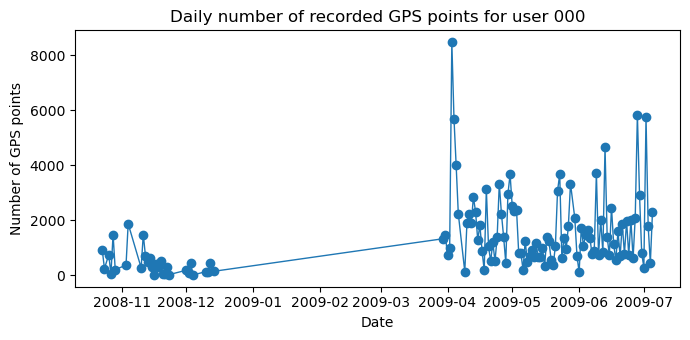

In [5]:
# Daily number of GPS points
day_counts = (
    traj
    .groupby("date_only")
    .size()
    .rename("n_points")
    .reset_index()
)

# Simple time-series style plot of counts per day
day_counts_plot = day_counts.copy()
day_counts_plot["date_only"] = pd.to_datetime(day_counts_plot["date_only"])

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3.5))
plt.plot(
    day_counts_plot["date_only"],
    day_counts_plot["n_points"],
    marker="o",
    linewidth=1
)
plt.xlabel("Date")
plt.ylabel("Number of GPS points")
plt.title("Daily number of recorded GPS points for user 000")
plt.tight_layout()
plt.show()


## 3. Spatial filter: restricting to the Beijing area

Geolife users may have trajectories in multiple cities.
In this project we focus on the Beijing region.
We therefore apply a simple bounding box filter on longitude and latitude.


In [6]:
if FILTER_BEIJING:
    minLon, minLat, maxLon, maxLat = BEIJING_BBOX
    before = len(traj)
    traj = traj[
        (traj["lon"] >= minLon) & (traj["lon"] <= maxLon) &
        (traj["lat"] >= minLat) & (traj["lat"] <= maxLat)
    ].copy()
    after = len(traj)
    print(f"Beijing filter: {before} -> {after} points")
else:
    print("Beijing filter is disabled.")

Beijing filter: 173870 -> 157646 points


## 4. Projection to UTM and construction of a 500 m grid
All GPS points are transformed from WGS84 geographic coordinates (lat/lon) to UTM Zone 50N so that distances can be measured in metres. In this projected space, a regular 500 m × 500 m grid is built to fully cover the user’s trajectory. Each GPS fix is then mapped to its corresponding grid cell (ci, rj).

This discretisation step reduces the influence of GPS jitter and avoids tracing every minor wiggle of the raw trajectories. Subsequent analyses operate at the cell level—using visits to grid cells instead of raw points—which stabilises behaviour patterns and prevents over-interpreting micro-movements that arise from measurement error or inconsistent sampling.

Using a fixed grid inevitably introduces a mild modifiable areal unit problem (MAUP): the exact boundaries and grid size may slightly influence which cells a point falls into. In this context, however, the 500 m resolution strikes a balance between reducing noise and retaining meaningful activity locations, making the grid a practical spatial unit for behavioural modelling.

In [7]:
def cell_center_lonlat(ci, rj):
    cx = gx0 + (ci + 0.5) * GRID_SIZE
    cy = gy0 + (rj + 0.5) * GRID_SIZE
    lon, lat = to_wgs(cx, cy)
    return lon, lat

# Coordinate reference systems
CRS_WGS84 = pyproj.CRS("EPSG:4326")
CRS_UTM50 = pyproj.CRS("EPSG:32650")
to_utm = pyproj.Transformer.from_crs(CRS_WGS84, CRS_UTM50, always_xy=True).transform
to_wgs = pyproj.Transformer.from_crs(CRS_UTM50, CRS_WGS84, always_xy=True).transform

# Lat/lon -> projected (metres)
x, y = to_utm(traj["lon"].values, traj["lat"].values)
traj["x"] = x
traj["y"] = y

GRID_SIZE = 500  # metres

# Grid extent with one extra cell of padding on each side
minx, miny = traj["x"].min(), traj["y"].min()
maxx, maxy = traj["x"].max(), traj["y"].max()

gx0 = math.floor(minx / GRID_SIZE) * GRID_SIZE - GRID_SIZE
gy0 = math.floor(miny / GRID_SIZE) * GRID_SIZE - GRID_SIZE
gx1 = math.ceil (maxx / GRID_SIZE) * GRID_SIZE + GRID_SIZE
gy1 = math.ceil (maxy / GRID_SIZE) * GRID_SIZE + GRID_SIZE

ncol = int((gx1 - gx0) / GRID_SIZE)
nrow = int((gy1 - gy0) / GRID_SIZE)
print(f"Grid columns × rows: {ncol} × {nrow} (total {ncol*nrow:,} cells)")

# Assign each point to a grid cell
traj["ci"] = ((traj["x"] - gx0) // GRID_SIZE).astype(int)
traj["rj"] = ((traj["y"] - gy0) // GRID_SIZE).astype(int)

traj[["datetime", "lat", "lon", "x", "y", "ci", "rj"]].head()


Grid columns × rows: 128 × 102 (total 13,056 cells)


datetime        lat         lon              x             y  ci  \
0 2008-10-23 02:53:04  39.984702  116.318417  441807.056623  4.426282e+06  43   
1 2008-10-23 02:53:10  39.984683  116.318450  441809.858037  4.426280e+06  43   
2 2008-10-23 02:53:15  39.984686  116.318417  441807.043048  4.426280e+06  43   
3 2008-10-23 02:53:20  39.984688  116.318385  441804.312590  4.426280e+06  43   
4 2008-10-23 02:53:25  39.984655  116.318263  441793.868245  4.426277e+06  43   

   rj  
0  50  
1  50  
2  50  
3  50  
4  50

## 5. Detecting HOME and SW from night-time points

I identify the user’s home location (HOME) and a secondary frequent place (SW)
from night-time points between 00:00 and 06:00, assuming that locations where
the user repeatedly appears at night are likely to be home-like places. In
practice, I first filter the trajectory to these hours and count how many
night-time points fall in each 500 m grid cell, also recording the time span
between the first and last night-time observation in that cell. HOME is
defined as the cell with the largest night-time count, breaking ties by the
longest time span. After removing this cell, SW is defined as the
second-strongest night-time cell, if such a candidate exists.



In [8]:
night = traj[(traj["hour"] >= 0) & (traj["hour"] < 6)].copy()
night["cell"] = list(zip(night["ci"], night["rj"]))
print("Number of night-time points:", len(night))

cell_counts = night["cell"].value_counts()
cell_counts.head()


Number of night-time points: 47296


cell
(44, 55)    4779
(43, 55)    3531
(44, 54)    3157
(45, 53)    2547
(43, 56)    2354
Name: count, dtype: int64

In [9]:
def night_span_seconds(cell):
    sub = night[night["cell"] == cell]["datetime"]
    return (sub.max() - sub.min()).total_seconds() if not sub.empty else 0

# HOME: cell with the largest night-time count; if tied, pick the one with largest time span
candidates = cell_counts[cell_counts == cell_counts.max()].index.tolist()
home_cell = max(candidates, key=night_span_seconds) if len(candidates) > 1 else cell_counts.index[0]

# SW: second-strongest night-time cell after removing HOME
cell_counts_wo_home = cell_counts[cell_counts.index != home_cell]
sw_cell = None
if not cell_counts_wo_home.empty:
    cand2 = cell_counts_wo_home[cell_counts_wo_home == cell_counts_wo_home.max()].index.tolist()
    sw_cell = max(cand2, key=night_span_seconds) if len(cand2) > 1 else cell_counts_wo_home.index[0]

home_lon, home_lat = cell_center_lonlat(*home_cell)
print(f"HOME cell = {home_cell} @ ({home_lon:.6f}, {home_lat:.6f})")

if sw_cell is not None:
    sw_lon, sw_lat = cell_center_lonlat(*sw_cell)
    print(f"SW   cell = {sw_cell} @ ({sw_lon:.6f}, {sw_lat:.6f})")
else:
    print("SW   cell = None")


HOME cell = (44, 55) @ (116.323385, 40.006970)
SW   cell = (43, 55) @ (116.317527, 40.006935)


## 6. Daily activity cells via line–grid intersections

Not every grid cell that contains a raw GPS point should be treated as an
“activity location”. Points along fast road segments are typically in transit
rather than places where the user actually stops. To obtain a more
conservative set of daily activity cells, the analysis works with line
segments rather than points: for each day, consecutive projected points are
connected into segments in the (x, y) plane, and for every grid cell the
number of segments intersecting its polygon is counted.

A cell is classified as an activity location if its number of intersecting
segments exceeds a daily threshold. The baseline threshold is set to 100
crossings, which is high enough to filter out most purely in-transit cells
while retaining the dense clusters around home and other frequently visited
areas. This value is chosen empirically by inspecting several days of data:
smaller thresholds admit long stretches of road as “places”, whereas larger
thresholds begin to discard plausible stops. The threshold is then adapted
on a day-by-day basis to avoid unrealistically rich days; if more than 30
cells exceed the threshold on a given day, the threshold is increased and
the classification is recomputed.


In [10]:
from shapely.geometry import LineString, box
from shapely.strtree import STRtree

# Parameters for the line–grid crossing rule
THRESH_START = 100          # initial threshold for "enough crossings"
THRESH_STEP  = 25          # how much to increase the threshold if a day has too many cells
THRESH_MAX   = 1000        # upper bound on the threshold

MAX_PLACES_PER_DAY = 30    # per day: at most this many DISTINCT activity cells (places)

# Cache for grid-cell polygons (speeds things up)
_poly_cache = {}

def cell_poly(ci, rj):
    """Return the shapely Polygon for grid cell (ci, rj)."""
    key = (ci, rj)
    if key not in _poly_cache:
        x0 = gx0 + ci * GRID_SIZE
        y0 = gy0 + rj * GRID_SIZE
        _poly_cache[key] = box(x0, y0, x0 + GRID_SIZE, y0 + GRID_SIZE)
    return _poly_cache[key]

def query_segments(tree, poly, segs):
    """
    Wrapper around STRtree.query to handle both 'index' and 'geometry' return types,
    depending on Shapely version.
    """
    res = tree.query(poly)
    if len(res) == 0:
        return []
    first = res[0]
    # Some Shapely versions return indices, some return geometries
    if isinstance(first, (int, np.integer)):
        return [segs[i] for i in res]
    return res

# Containers for results
visited_cells_by_day = {}   # date -> set of (ci, rj) cells considered "activity locations"
cross_threshold_used = {}   # date -> threshold value actually used for that day

# We iterate over each date present in the trajectory
dates = sorted(traj["date_only"].unique().tolist())
print(f"Number of days with data for user {USER_ID}: {len(dates)}")

for d in dates:
    # All points for this day, ordered in time
    day = traj[traj["date_only"] == d].sort_values("datetime").copy()
    if len(day) < 2:
        # Not enough points to form line segments
        visited_cells_by_day[d] = set()
        cross_threshold_used[d] = THRESH_START
        continue

    # Build line segments between consecutive points (in projected coordinates)
    pts = list(zip(day["x"].values, day["y"].values))
    segs = [LineString([pts[i], pts[i+1]]) for i in range(len(pts) - 1)]

    # Drop empty / zero-length segments
    segs = [s for s in segs if (not s.is_empty) and (s.length > 0)]
    if not segs:
        visited_cells_by_day[d] = set()
        cross_threshold_used[d] = THRESH_START
        continue

    tree = STRtree(segs)

    # Only check the grid cells that actually appear for this day
    cmin, cmax = int(day["ci"].min()), int(day["ci"].max())
    rmin, rmax = int(day["rj"].min()), int(day["rj"].max())

    # Start from the base threshold and adapt if needed
    thr = THRESH_START
    while True:
        today_cells = set()

        # Loop over all relevant grid cells for that day
        for ci in range(cmin, cmax + 1):
            for rj in range(rmin, rmax + 1):
                poly = cell_poly(ci, rj)
                cnt = 0

                # Candidate segments intersecting this cell
                for seg in query_segments(tree, poly, segs):
                    if seg.intersects(poly):
                        cnt += 1
                        if cnt >= thr:
                            today_cells.add((ci, rj))
                            break   # no need to count further for this cell

        # If the day has too many activity CELLS, raise the threshold and try again
        if len(today_cells) > MAX_PLACES_PER_DAY and thr < THRESH_MAX:
            thr = min(thr + THRESH_STEP, THRESH_MAX)
        else:
            visited_cells_by_day[d] = today_cells
            cross_threshold_used[d] = thr
            break

# Summarise: how many activity cells per day, and what threshold was used
perday_summary = (
    pd.DataFrame({
        "date": [str(d) for d in dates],
        "visited_cells": [len(visited_cells_by_day[d]) for d in dates],
        "threshold_used": [cross_threshold_used[d] for d in dates],
    })
    .sort_values("date")
    .reset_index(drop=True)
)

print("Daily activity-cell counts (first 10 days):")
perday_summary.head(10)


Number of days with data for user 000: 122
Daily activity-cell counts (first 10 days):


date  visited_cells  threshold_used
0  2008-10-23              3             100
1  2008-10-24              1             100
2  2008-10-26              2             100
3  2008-10-27              0             100
4  2008-10-28              3             100
5  2008-10-29              0             100
6  2008-11-03              0             100
7  2008-11-04              4             100
8  2008-11-10              0             100
9  2008-11-11              4             100

## 7. From daily activity cells to visit-level events

Given the set of daily activity cells, I next distinguish first-time places
from returns and compress the trajectories into visit-level events. Across
the whole observation window, a grid cell is labelled as a first-time place
(Pv) on the first date on which it appears as an activity cell; on any later
day when the same cell is active it is treated as a return place (Pn). HOME
and SW are kept as separate categories and override the Pv/Pn labels.

Using these labels, I then build the visit-level table day by day. For each
calendar day, the sequence of grid cells visited by the user is first
compressed with a simple run-length encoding, so that consecutive points in
the same cell form a single block. Each block is looked up in the activity
cell set for that day and assigned a tag HOME, SW, Pv or Pn; blocks that are
not classified as activity locations are dropped as in-transit segments. 
Adjacent blocks with the same cell and tag are merged so that brief GPS
losses do not split a single stay into multiple visits.

The remaining blocks define the visit events. For each visit I record its
start and end time, duration, grid indices and cell centre (in both
projected and geographic coordinates), distance to HOME, and a place
identifier (HOME, SW, Pv#, Pn#). I also keep two within-day order variables:
a running visit order that counts all visits during the day, and an
action-order index that restarts at 1 when the user leaves HOME and resets
to 0 when they return. Finally, each visit is given a next_step label
indicating whether the following visit is to home, SW, a Pv, a Pn, or none
(end of the day). Stacking all days produces the final visit-level table,
which is saved as visit_level_table_000.csv and used as input for the
subsequent notebooks.


In [11]:
from datetime import timedelta

pv_label = {}              # (ci, rj) -> "Pv#"
pn_label = {}              # ((ci, rj), date) -> "Pn#"
first_visit_date = {}      # (ci, rj) -> first date when this cell is an activity cell

pv_counter = 0
pn_counter = 0

for d in sorted(visited_cells_by_day.keys()):
    cells = visited_cells_by_day[d]
    for cell in sorted(cells):
        if cell not in first_visit_date:
            # First time this activity cell appears in the whole sample -> Pv
            pv_counter += 1
            first_visit_date[cell] = d
            pv_label[cell] = f"Pv{pv_counter}"
        else:
            # Subsequent days when the same activity cell is active -> Pn
            pn_counter += 1
            pn_label[(cell, d)] = f"Pn{pn_counter}"

print(f"Total unique Pv cells: {len(pv_label)}")
print(f"Total Pn labels assigned: {len(pn_label)}")


# --- 7.2 Helper: classify a cell on a given day ---

def classify_cell(cell, day_date):
    """
    Classify a grid cell on a given date into:
      - ('home', 'HOME')
      - ('sw', 'SW')
      - ('pv', 'Pv#')
      - ('pn', 'Pn#')
      - ('none', '')  for cells that are not treated as activity locations on that day.
    """
    if cell == home_cell:
        return "home", "HOME"
    if (sw_cell is not None) and (cell == sw_cell):
        return "sw", "SW"

    visited_today = visited_cells_by_day.get(day_date, set())
    if cell in visited_today:
        if first_visit_date.get(cell) == day_date:
            return "pv", pv_label[cell]
        else:
            return "pn", pn_label.get((cell, day_date), "PN")

    return "none", ""


def cell_center_xy(ci, rj):
    """Return the projected (x, y) centre of grid cell (ci, rj)."""
    cx = gx0 + (ci + 0.5) * GRID_SIZE
    cy = gy0 + (rj + 0.5) * GRID_SIZE
    return cx, cy


# --- 7.3 Build the merged visit-level table ---

visit_rows = []
all_dates = sorted(traj["date_only"].unique().tolist())

for d in all_dates:
    day = traj[traj["date_only"] == d].sort_values("datetime").copy()
    if day.empty:
        continue

    # Sequence of grid cells and timestamps for this day
    cells = list(zip(day["ci"].astype(int), day["rj"].astype(int)))
    times = day["datetime"].tolist()

    # 1) Raw run-length encoding by grid cell:
    #    consecutive identical (ci, rj) are grouped into one block.
    runs = []  # list of (cell, i0, i1) with indices into 'times'
    if cells:
        start = 0
        for i in range(1, len(cells)):
            if cells[i] != cells[i-1]:
                runs.append((cells[i-1], start, i-1))
                start = i
        runs.append((cells[-1], start, len(cells) - 1))

    # 2) Attach labels and time bounds; drop blocks that are not activity cells
    tagged = []
    for (cell, i0, i1) in runs:
        tag, pid = classify_cell(cell, d)
        if tag == "none":
            continue  # ignore transit-only cells
        tagged.append({
            "cell": cell,
            "ci": cell[0],
            "rj": cell[1],
            "tag": tag,
            "place_id": pid,
            "i0": i0,
            "i1": i1,
            "first_dt": times[i0],
            "last_dt": times[i1],
        })

    if not tagged:
        continue

    # 3) Merge adjacent blocks with the same (ci, rj, tag)
    merged = []
    current = tagged[0]
    for nxt in tagged[1:]:
        if (
            (nxt["ci"] == current["ci"]) and
            (nxt["rj"] == current["rj"]) and
            (nxt["tag"] == current["tag"])
        ):
            # extend the current block
            current["i1"] = nxt["i1"]
            current["last_dt"] = nxt["last_dt"]
        else:
            merged.append(current)
            current = nxt
    merged.append(current)

    # 4) For each merged visit, compute attributes and within-day order
    visit_order = 0     
    action_order = 0    

    for k, rec in enumerate(merged):
        ci, rj = rec["ci"], rec["rj"]
        tag, pid = rec["tag"], rec["place_id"]
        first_dt, last_dt = rec["first_dt"], rec["last_dt"]

        visit_order += 1

        if tag == "home":
            action_order = 0    
            action_ord = 0
        else:
            if action_order == 0:
                action_order = 1  
            else:
                action_order += 1
            action_ord = action_order

        # Next-step label (based on the next merged block)
        if k < len(merged) - 1:
            next_tag = merged[k + 1]["tag"]
        else:
            next_tag = "none"

        # Geometry-based attributes
        cx, cy = cell_center_xy(ci, rj)
        hx, hy = cell_center_xy(*home_cell)
        dist_home = math.hypot(cx - hx, cy - hy)
        center_lon, center_lat = cell_center_lonlat(ci, rj)

        visit_rows.append({
            "person": USER_ID,
            "date": d.isoformat(),
            "first_time": first_dt.time().isoformat(),
            "last_time": last_dt.time().isoformat(),
            "duration_min": round((last_dt - first_dt) / timedelta(minutes=1), 1),
            "grid_ci": ci,
            "grid_rj": rj,
            "grid_center_lon": round(center_lon, 6),
            "grid_center_lat": round(center_lat, 6),
            "dist_home_m": round(dist_home, 1),
            "is_home": 1 if tag == "home" else 0,
            "is_sw":   1 if tag == "sw"   else 0,
            "is_pv":   1 if tag == "pv"   else 0,
            "is_pn":   1 if tag == "pn"   else 0,
            "place_id": pid,          # HOME / SW / Pv# / Pn#
            "next_step": next_tag,    # home / sw / pv / pn / none
            "visit_order_in_day": visit_order,  
            "action_order": action_ord         
        })

# Final visit-level table
visit_table = (
    pd.DataFrame(visit_rows)
    .sort_values(["date", "first_time", "grid_ci", "grid_rj"])
    .reset_index(drop=True)
)

print("Number of visit events:", len(visit_table))
visit_table.head(10)


Total unique Pv cells: 106
Total Pn labels assigned: 294
Number of visit events: 1841


person        date first_time last_time  duration_min  grid_ci  grid_rj  \
0    000  2008-10-23   03:00:55  04:13:32          72.6       40       50   
1    000  2008-10-23   09:42:25  09:42:30           0.1       43       55   
2    000  2008-10-23   09:42:35  10:05:29          22.9       44       55   
3    000  2008-10-23   10:05:34  10:30:15          24.7       43       55   
4    000  2008-10-23   10:30:20  11:10:57          40.6       44       55   
5    000  2008-10-24   02:09:59  02:10:54           0.9       43       55   
6    000  2008-10-24   02:10:59  02:47:06          36.1       44       55   
7    000  2008-10-26   14:04:27  14:12:42           8.2       55       33   
8    000  2008-10-26   14:23:42  14:35:17          11.6       56       31   
9    000  2008-10-27   12:03:59  12:05:54           1.9       44       55   

   grid_center_lon  grid_center_lat  dist_home_m  is_home  is_sw  is_pv  \
0       116.300184        39.984308       3201.6        0      0      1   
1       116.317527        40.006935        500.0        0      1      0   
2       116.323385        40.006970          0.0        1      0      0   
3       116.317527        40.006935        500.0        0      1      0   
4       116.323385        40.006970          0.0        1      0      0   
5       116.317527        40.006935        500.0        0      1      0   
6       116.323385        40.006970          0.0        1      0      0   
7       116.388704        39.908225      12298.4        0      0      1   
8       116.394633        39.899246      13416.4        0      0      1   
9       116.323385        40.006970          0.0        1      0      0   

   is_pn place_id next_step  visit_order_in_day  action_order  
0      0      Pv1        sw                   1             1  
1      0       SW      home                   2             2  
2      0     HOME        sw                   3             0  
3      0       SW      home                   4             1  
4      0     HOME      none                   5             0  
5      0       SW      home                   1             1  
6      0     HOME      none                   2             0  
7      0      Pv4        pv                   1             1  
8      0      Pv5      none                   2             2  
9      0     HOME      none                   1             0

In [12]:
# save visit-level table for later notebooks
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

out_path = os.path.join(OUT_DIR, f"visit_level_table_{USER_ID}.csv")
visit_table.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved visit-level table to:", out_path)


Saved visit-level table to: data\visit_level_table_000.csv


## 8. Mapping inferred activity places

To summarise the cleaned visit-level data, I project the inferred activity
locations back onto an interactive map. Starting from the visit table, I
collapse repeated visits to the same 500 m grid cell and draw one square for
each distinct cell that ever appears as a visit. Each cell is coloured
according to its role in the visit history (explored at least once versus
only revisited), while the HOME and SW cells are highlighted separately as
point markers. Compared with the raw trajectories, this map shows a much
simpler picture of the user’s daily activity space: a small set of recurrent
places organised around home, rather than every individual GPS point and
transit segment.


In [13]:
# --- 8.1 Aggregate unique places from the visit-level table ---

# We keep only non-home visits (HOME is shown separately as a point),
# and collapse repeated visits to the same grid cell.
places = (
    visit_table
    .groupby(["grid_ci", "grid_rj"], as_index=False)
    .agg(
        any_home=("is_home", "max"),
        any_sw=("is_sw", "max"),
        any_pv=("is_pv", "max"),
        any_pn=("is_pn", "max"),
        grid_center_lon=("grid_center_lon", "first"),
        grid_center_lat=("grid_center_lat", "first"),
        dist_home_m=("dist_home_m", "min")
    )
)


print("Number of unique grid cells appearing in visits:", len(places))


# --- 8.2 Helper: cell polygon in lat/lon ---

def cell_bounds_lonlat(ci, rj):
    """
    Return the 4 corners (and closed ring) of grid cell (ci, rj)
    as (lat, lon) pairs for use in folium.Polygon.
    """
    x0 = gx0 + ci * GRID_SIZE
    y0 = gy0 + rj * GRID_SIZE
    x1 = x0 + GRID_SIZE
    y1 = y0 + GRID_SIZE

    lon0, lat0 = to_wgs(x0, y0)
    lon1, lat1 = to_wgs(x1, y0)
    lon2, lat2 = to_wgs(x1, y1)
    lon3, lat3 = to_wgs(x0, y1)

    # folium expects (lat, lon)
    return [
        (lat0, lon0),
        (lat1, lon1),
        (lat2, lon2),
        (lat3, lon3),
        (lat0, lon0),
    ]


# --- 8.3 Colour rule for places ---

def color_for_place(row):
    cell = (int(row["grid_ci"]), int(row["grid_rj"]))
    # HOME and SW will be shown as point markers; here we colour only squares
    if sw_cell is not None and cell == sw_cell:
        return "green"
    # Pv vs Pn logic
    if row["any_pn"] == 1:
        return "orange"   # ever seen as Pv at least once
    if row["any_pv"] == 1:
        return "purple"   # only returns
    return "gray"


# --- 8.4 Initialise a folium map centred at HOME ---

# Compute HOME centre in lat/lon (from grid indices)
hx = gx0 + (home_cell[0] + 0.5) * GRID_SIZE
hy = gy0 + (home_cell[1] + 0.5) * GRID_SIZE
home_lon, home_lat = to_wgs(hx, hy)

m = folium.Map(location=[home_lat, home_lon],
               zoom_start=12,
               tiles="cartodbpositron")


# --- 8.5 Add grid-cell polygons for activity places ---

for _, row in places.iterrows():
    ci = int(row["grid_ci"])
    rj = int(row["grid_rj"])
    poly_latlon = cell_bounds_lonlat(ci, rj)
    col = color_for_place(row)

    popup_html = (
        f"Cell: ({ci}, {rj})<br>"
        f"Center: ({row['grid_center_lat']:.5f}, {row['grid_center_lon']:.5f})<br>"
        f"Dist. to HOME: {int(round(row['dist_home_m']))} m<br>"
        f"Any Pv: {int(row['any_pv'])} &nbsp; Any Pn: {int(row['any_pn'])}"
    )

    folium.Polygon(
        locations=poly_latlon,
        color=col,
        weight=2,
        fill=True,
        fill_opacity=0.35,
        popup=popup_html
    ).add_to(m)


# --- 8.6 Add HOME and SW as point markers ---

folium.CircleMarker(
    location=[home_lat, home_lon],
    radius=7,
    color="blue",
    fill=True,
    fill_opacity=0.9,
    popup="HOME"
).add_to(m)

if sw_cell is not None:
    sx = gx0 + (sw_cell[0] + 0.5) * GRID_SIZE
    sy = gy0 + (sw_cell[1] + 0.5) * GRID_SIZE
    sw_lon, sw_lat = to_wgs(sx, sy)

    folium.CircleMarker(
        location=[sw_lat, sw_lon],
        radius=7,
        color="green",
        fill=True,
        fill_opacity=0.9,
        popup="SW"
    ).add_to(m)


m


Number of unique grid cells appearing in visits: 106
